In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

DATA_DIR = '/content/drive/My Drive/proto_data/'
PICKLED_DIR = os.path.join(DATA_DIR, 'pickled/')
#CONLLU_DIR = os.path.join(DATA_DIR, 'WSJ_conllus/')
#MODEL_DIR = '../saved_models/'

PROTO_TSV = os.path.join(DATA_DIR, 'protoroles_eng_pb_08302015.tsv')
#GLOVE_FILE = {'100': os.path.join(DATA_DIR, 'glove.6B.100d.txt') }

SPLITS = ['train', 'dev', 'test'] 

PROPERTIES = ['instigation', 'volition', 'awareness', 'sentient',
'exists_as_physical', 'existed_before', 'existed_during', 'existed_after',
'created', 'destroyed', 'predicate_changed_argument', 'change_of_state', 
'changes_possession', 'change_of_location', 'stationary', 'location_of_event', 
'makes_physical_contact', 'manipulated_by_another']

PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'


In [0]:
import sys
sys.path.insert(0, '/content/drive/My Drive/proto_modules')

In [5]:
from collections import defaultdict
import os
import pickle
from tqdm import tqdm
import random
import math

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

#import data_utils

device:  cuda:0


In [0]:
from torch import unsqueeze
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, \
        pack_padded_sequence, pad_sequence


class Attention(nn.Module):
  def __init__(self,
               n_properties=None,
               specific_size=None):
    super(Attention, self).__init__()

    self.n_properties = n_properties

    self.layer_norm = nn.LayerNorm(self.n_properties * specific_size)

  def forward(self, x):
    B = x.shape[0]

    x = x.view(B, self.n_properties, -1) # (B, n_props, size_specific)

    attn_scores = torch.bmm(x, torch.transpose(x, 2, 1)) # (B, n_props, n_props)
    dists = F.softmax(attn_scores, -1)
    attn_weighted_sum = torch.bmm(dists, x)

    x = x + attn_weighted_sum

    x = self.layer_norm(x.view(B, -1))

    return x


class SPRL(nn.Module):
    def __init__(self,
            vocab_size=None,
            emb_size=None,
            h_size=None,
            shared_size=None,
            padding_idx=None,
            emb_np=None,
            properties=None,
            use_attention=True):
        super(SPRL, self).__init__()

        self.properties = properties
        self.n_properties = len(properties)

        self.word_emb = nn.Embedding(
                vocab_size,
                emb_size,
                padding_idx=padding_idx)
        self.word_emb.weight.data.copy_(torch.Tensor(emb_np))
        self.word_emb.weight.requires_grad = False

        directions = 2
        self.lstm = MyLSTM(
            emb_size=emb_size,
            h_size=h_size,
            directions=directions,
            properties=properties)

        concatenated_embs_size = 2*(directions*h_size) # If using LSTM
        #concatenated_embs_size = (2*emb_size) # If using DAN

        self.attention = None
        if not use_attention:
          #shared_size=concatenated_embs_size
          #shared_size=self.n_properties

          self.first_guess = nn.Sequential(
              nn.Linear(concatenated_embs_size, self.n_properties, bias=True),
              )
          self.updates = nn.Sequential(
              nn.Linear(self.n_properties, self.n_properties, bias=False),
              nn.Tanh()
              )
          
          #self.clf = nn.Linear(self.n_properties*shared_size, self.n_properties, bias=True)
          #self.clf = nn.Linear(shared_size, self.n_properties, bias=True)
        else: # "shared" not really best name here...
          specific_size = int(concatenated_embs_size / 2)
          self.shared = nn.Sequential(
            nn.Linear(self.n_properties*concatenated_embs_size, self.n_properties * specific_size, bias=True),
            nn.ReLU())
          
          self.attention = Attention(n_properties=self.n_properties, specific_size=specific_size)

          self.clf = nn.Linear(self.n_properties*specific_size, self.n_properties, bias=True)


    def forward(self, sents, sent_lens, preds, heads):

        # Sort the sentences so that the LSTM can process properly
        lens_sorted = sent_lens
        words_sorted = sents
        indices = None
        if(len(sents) > 1):
            lens_sorted, indices = torch.sort(lens_sorted, descending=True)
            lens_sorted = lens_sorted.to(device)
            indices = indices.to(device)
            words_sorted = words_sorted.index_select(0, indices).to(device)

        w_embs = self.word_emb(words_sorted)

        packed_lstm_input = pack_padded_sequence(
                w_embs, lens_sorted, batch_first=True)

        lstm_outs = self.lstm(packed_lstm_input, indices)

        # lstm_outs : (B, L, h_size), assuming preds (B)
        B, L, h_size = lstm_outs.shape
        pred_reps = lstm_outs[np.arange(B), preds] # expecting (B, h_size)
        head_reps = lstm_outs[np.arange(B), heads] # same as above

        # DAN version
        # lstm_outs = self.word_emb(sents)
        # B, L, h_size = lstm_outs.shape
        # pred_reps = lstm_outs[np.arange(B), preds] # expecting (B, h_size)
        # head_reps = lstm_outs[np.arange(B), heads] # same as above

        # Get pred-arg representation (same for DAN and LSTM)
        pred_head_cat = torch.cat([pred_reps, head_reps], dim=-1) # (B, 2*h_size)

        if self.attention == None:
          first_guess = self.first_guess(pred_head_cat) # (B, size_shared) # For lstm
          #clf_input = clf_input.repeat(1, self.n_properties) # Don't repeat on axis 0
          updates = self.updates(first_guess) # (B, size_shared) # For lstm
          #logits = self.clf(shared_out) # (B, properties)
          logits = first_guess + updates # Residual model
        else:
          attn_input = self.shared(pred_head_cat.repeat(1, self.n_properties)) # (B, n_properties * size_specific)
          clf_input = self.attention(attn_input)
          logits = self.clf(clf_input)

        return logits

    def predict(self, sents, sent_lens, preds, heads):

        logits = self.forward(sents, sent_lens, preds, heads)
        predictions = (logits.sign() + 1) / 2

        return predictions


class MyLSTM(nn.Module):
    def __init__(self,
            emb_size=None,
            h_size=None,
            directions=None,
            properties=None):
        super(MyLSTM, self).__init__()

        self.lstm = nn.LSTM(
                input_size=emb_size,    
                hidden_size=h_size,
                num_layers=1,
                bidirectional=(directions == 2),
                batch_first=True,
                dropout=0.1,
                bias=True)
        
        self.lstm_drop = nn.Dropout(0.)

    def forward(self, packed_lstm_input, indices):
        outputs, _ = self.lstm(packed_lstm_input)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)

        # Unsort sentences to return to proper alignment with labels
        if len(outputs) > 1:
            outputs = unsort(outputs, indices)
          
        outputs = self.lstm_drop(outputs)

        return outputs

 
def unsort(batch, indices):
    indices_inverted = torch.argsort(indices)
    batch = batch.index_select(0, indices_inverted)
    return batch

In [0]:

def train_lstm(args, model, X, y):
    epochs = args['epochs']
    batch_size = args['batch_size']
    lr = args['lr']

    for name, param in model.named_parameters():
      if name == 'updates.0.weight':
        original_weights = torch.tensor(param)

    # Data loaders
    loader_train = data_loader(X['train'], y['train'],
            batch_size=batch_size, shuffle_idx=True)
    loader_dev = data_loader(X['dev'], y['dev'],
            batch_size=batch_size, shuffle_idx=False)
    n_train_batches = math.ceil(len(X['train']) / batch_size)
    n_dev_batches = math.ceil(len(X['dev']) / batch_size)

    # Optimizer
    opt = Adam(model.parameters(), lr=lr, betas=[0.9, 0.999])

    # Train loop
    try:
        for e in range(epochs):
            model.train()
            for b in tqdm(
                    range(n_train_batches), 
                    ascii=True, 
                    desc=f'Epoch {e+1}/{epochs} progress',
                    position=0,
                    leave=True,
                    ncols=80):
                opt.zero_grad()
                sents, sent_lens, preds, heads, labels = next(loader_train)
                logits = model(sents, sent_lens, preds, heads)
                loss = bce_loss(logits, labels)
                loss.backward()
                opt.step()
        
            with torch.no_grad():
              model.eval()
              tp = 0
              fp = 0
              fn = 0
              for b in tqdm(range(n_dev_batches), ascii=True, desc=f'Evaluating progress', ncols=80, position=0, leave=True):
                sents, sent_lens, preds, heads, labels = next(loader_dev)
                results_, metrics_ = evaluate(args, model, sents, sent_lens, preds, heads, labels)
                tp += results_['tp']
                fp += results_['fp']
                fn += results_['fn']

              for name, param in model.named_parameters():
                if name == 'updates.0.weight':
                  updates_weights = param
              with torch.no_grad():
                show_weights((updates_weights - original_weights).cpu(), properties=model.properties)
              
              F, precision, recall = F_precision_recall(tp, fp, fn)

              print(f"Epoch {e}, F={F*100:.2f}, p={precision*100:.2f}, r={recall*100:.2f}")

    except KeyboardInterrupt:
        pass
    # End of train loop

    # Eval time!
    model.eval()
    with torch.no_grad():
      tp = 0
      fp = 0
      fn = 0
      for b in tqdm(range(n_dev_batches), ascii=True, desc=f'Evaluating progress', ncols=80):
        sents, sent_lens, preds, heads, labels = next(loader_dev)
        results_, metrics_ = evaluate(args, model, sents, sent_lens, preds, heads, labels)
        tp += results_['tp']
        fp += results_['fp']
        fn += results_['fn']
      
      F, precision, recall = F_precision_recall(tp, fp, fn)

      print(f"F={F*100:.2f}, p={precision*100:.2f}, r={recall*100:.2f}")
    
    return


def show_weights(weights, properties=None, cmap='RdBu'):
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(properties)))
    ax.set_yticks(np.arange(len(properties)))
    ax.set_xticklabels(properties)
    ax.set_yticklabels(properties)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")

    plt.imshow(weights, cmap=cmap)
    cbar = plt.colorbar()

    return


def bce_loss(logits, labels):
    # Expected labels : (B, num_properties)
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    return loss


def data_loader(X, y, batch_size=None, shuffle_idx=False):
    data = list(zip(X, y))
    idx = list(range(len(data)))
    while True:
        if shuffle_idx:
            random.shuffle(idx) # In-place shuffle
        
        for span in idx_spans(idx, batch_size):
            batch = [data[i] for i in span]
            yield prepare_batch(batch)


def idx_spans(idx, span_size):
    for i in range(0, len(idx), span_size):
        yield idx[i:i+span_size]


def prepare_batch(batch):
    # batch[i] = X, y
    batch_size = len(batch)
    sent_lens = torch.LongTensor([len(x[0][0]) for x in batch])
    max_length = torch.max(sent_lens).item()
    n_properties = len(batch[0][1])

    # Zero is padding index
    sents = torch.zeros((batch_size, max_length)).long().to(device)
    preds = torch.zeros(batch_size).long().to(device)
    heads = torch.zeros(batch_size).long().to(device)
    labels = torch.zeros(batch_size, n_properties).to(device)

    for i, (X_batch, y_batch) in enumerate(batch):
        sent, (pred_idx, head_idx) = X_batch
        sents[i,:len(sent)] = torch.LongTensor(sent)
        preds[i] = pred_idx
        heads[i] = head_idx
        labels[i] = torch.tensor(y_batch)

    return sents, sent_lens, preds, heads, labels

In [0]:
def evaluate(args, model, sents, sent_lens, preds, heads, labels):
    # Get predictions
    predictions = model.predict(sents, sent_lens, preds, heads)

    predictions, labels = predictions.cpu().numpy(), labels.cpu().numpy()
    n_correct = (predictions == labels).astype(int).sum()

    # Precision, Recall
    eq = predictions == labels
    neq = predictions != labels

    pos_preds = predictions == 1
    neg_preds = predictions == 0

    tp = np.where(pos_preds, eq, 0).astype(int).sum()
    fp = np.where(pos_preds, neq, 0).astype(int).sum()
    fn = np.where(neg_preds, neq, 0).astype(int).sum()
    
    results = {
            'tp': tp,
            'fp': fp,
            'fn': fn
            }

    F, precision, recall = F_precision_recall(tp, fp, fn)
    metrics = {'F': F, 'precision': precision, 'recall': recall}

    return results, metrics


def F_precision_recall(tp, fp, fn):
    if tp + fp > 0.:
        precision = tp / (tp + fp)
    else:
        precision = 0.

    if tp + fn > 0.:
        recall = tp / (tp + fn)
    else:
        recall = 0.

    if precision + recall > 0.:
        F = (2 * precision * recall) / (precision + recall)
    else:
        F = 0.

    return F, precision, recall


def micro_average(results):
    tp, fp, fn = 0, 0, 0
    for v in results.values():
        tp += v['tp']
        fp += v['fp']
        fn += v['fn']
    
    return F_precision_recall(tp, fp, fn)


In [0]:
def get_data(args):
    df = pd.read_csv(PROTO_TSV, sep='\t')

    # Sentences
    sent_ids = set(df['Sentence.ID'].tolist())
    sents_path = os.path.join(PICKLED_DIR, 'sents.pkl')
    sents = None
    with open(sents_path, 'rb') as f:
      sents = pickle.load(f)

    # Dependency data
    # dependencies_path = os.path.join(PICKLED_DIR, 'dependencies.pkl')
    # with open(dependencies_path, 'rb') as f:
    #     deps, deps_just_tokens = pickle.load(f)  
    # sents['dependencies'] = deps
    # sents['deps_just_tokens'] = deps_just_tokens


    # Instances
    path = os.path.join(PICKLED_DIR, 'instances.pkl')
    proto_instances = None
    possible = None # Data to compare to SPRL paper
    with open(path, 'rb') as f:
      proto_instances, possible = pickle.load(f)

    # Word embedding data
    w2e = None
    path = os.path.join(PICKLED_DIR, f"glove_{args['glove_d']}.pkl")
    with open(path, 'rb') as f:
      w2e = pickle.load(f)

    w2i, i2w = None, None
    emb_np = None
    X, y = None, None
    dicts_path = os.path.join(PICKLED_DIR, 'dicts.pkl')
    with open(dicts_path, 'rb') as f:
        w2i, i2w = pickle.load(f)
    
    emb_np_path = os.path.join(PICKLED_DIR, 'emb_np.pkl')
    with open(emb_np_path, 'rb') as f:
        emb_np = pickle.load(f)
    
    lstm_data_path = os.path.join(PICKLED_DIR, 'lstm_data.pkl')
    with open(lstm_data_path, 'rb') as f:
        X, y = pickle.load(f)

    return {'df': df, 
            'proto_instances': proto_instances, 
            'possible': possible,
            'sents': sents,
            'w2e': w2e,
            'sent_ids': sent_ids,
            'lstm_data': (X,y),
            'dicts': (w2i, i2w),
            'emb_np': emb_np}


In [0]:
def co_occurences(y_train):
  n_properties = y_train[0].shape[0]
  co_occur = np.zeros((n_properties, n_properties))
  anti_occur = np.zeros((n_properties, n_properties))
  for labels in y_train:
    for i in range(n_properties):
      for j in range(i+1, n_properties):
        if labels[i] == 1:
          if labels[i] == labels[j]:
            co_occur[i,j] += 1
            co_occur[j,i] += 1
          else:
            anti_occur[i,j] += 1
            anti_occur[j,i] += 1

  return co_occur, anti_occur

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
Epoch 2/4 progress:   5%|#2                      | 4/78 [00:00<00:02, 29.03it/s]

Epoch 0, F=75.95, p=76.64, r=75.27


Epoch 3/4 progress:   4%|9                       | 3/78 [00:00<00:02, 27.47it/s]

Epoch 1, F=78.45, p=79.36, r=77.55


Epoch 4/4 progress:   4%|9                       | 3/78 [00:00<00:02, 28.46it/s]

Epoch 2, F=79.58, p=80.43, r=78.74


Evaluating progress: 100%|######################| 10/10 [00:00<00:00, 53.59it/s]

Epoch 3, F=80.34, p=82.18, r=78.57
F=80.34, p=82.18, r=78.57


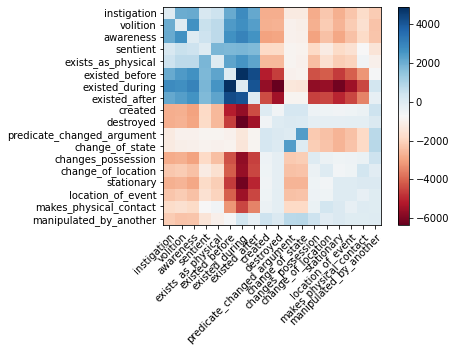

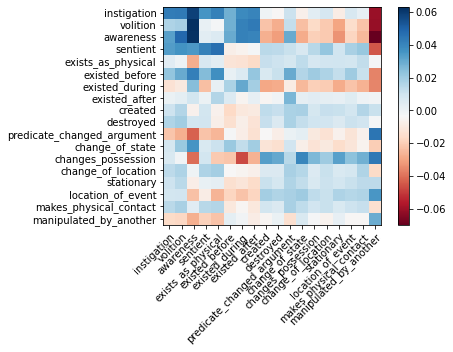

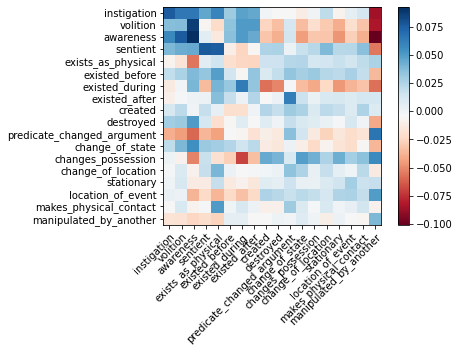

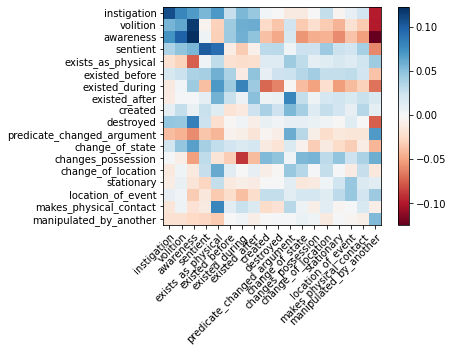

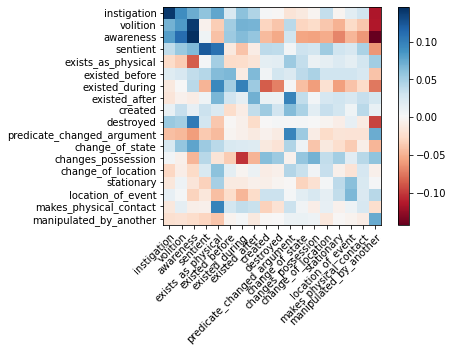

In [28]:
args = {
    'epochs': 4,
    'seed': 7,
    'lr': 1e-3,
    'batch_size': 100,
    'h_size': 300,
    #'shared_size': 300,
    'glove_d': 300,
    'use_attention': False
}

seed = args['seed']

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

data = get_data(args)

w2i, i2w = data['dicts']
emb_np = data['emb_np']
X, y = data['lstm_data']

co_occur, anti_occur = co_occurences(y['train'])
# show_weights(co_occur, properties=PROPERTIES, cmap='Greens')
# show_weights(anti_occur, properties=PROPERTIES, cmap='Reds')
show_weights(co_occur - anti_occur, properties=PROPERTIES)


model = SPRL(
    vocab_size=len(w2i),
    emb_size=int(args['glove_d']),
    h_size=args['h_size'],
    #shared_size=args['shared_size'],
    padding_idx=w2i[PAD_TOKEN],
    emb_np=emb_np,
    properties=PROPERTIES,
    use_attention=args['use_attention'])
model.to(device)

train_lstm(args, model, X, y)